In [1]:
import raphtory as rp
import csv
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt
import datetime as dt
%pip install distinctipy
import distinctipy
from plotting_utils import *

Note: you may need to restart the kernel to use updated packages.


In [2]:
from importlib.metadata import version
version('raphtory')

'0.4.0'

In [3]:
file = "/Users/naomiarnold/CODE/Raphtory/raphtory-research/stackexchange/sx-mathoverflow.txt"
sx_df = pd.read_csv(file, names = ["src", "dst", "time"],sep=" ")
display(sx_df)

,src,dst,time
0,1,4,1254192988
1,3,4,1254194656
2,1,2,1254202612
3,25,1,1254232804
4,14,16,1254263166
...,...,...,...
506545,21349,88580,1457260401
506546,20031,1114,1457261526
506547,51428,1114,1457261724
506548,56259,56259,1457261848


In [4]:
display(sx_df.groupby("time").count().sort_values(by='dst',ascending=False))

,src,dst
time,,
1371431393,3,3
1410194369,3,3
1379376677,3,3
1362350480,3,3
1456777834,3,3
...,...,...
1308343828,1,1
1308343095,1,1
1308343004,1,1


In [5]:
def load_pandas(data:pd.DataFrame):
    g = rp.Graph()
    for row in data.itertuples():
        g.add_vertex(row[3],row[1])
        g.add_vertex(row[3],row[2])
        if row[2]!=row[1]:
            g.add_edge(row[3],row[1],row[2])
    return g

In [6]:
g = rp.Graph(1)
for row in sx_df.itertuples():
    g.add_vertex(row[3],row[1])
    g.add_vertex(row[3],row[2])
    if row[2]!=row[1]:
        g.add_edge(row[3],row[1],row[2])

In [11]:
views_daily = g.rolling(window=86400)
views_weekly = g.rolling(window=604800,step=86400)
views_monthly = g.rolling(window="30 days",step="1 day")

In [15]:
degrees = sorted([(v.id(), v.in_degree()) for v in g.vertices()], key = lambda x: x[1], reverse=True)
print(degrees[:10])

[(11142, 968), (6094, 914), (290, 910), (297, 724), (1946, 721), (2841, 551), (18060, 539), (1459, 536), (1409, 506), (1149, 477)]


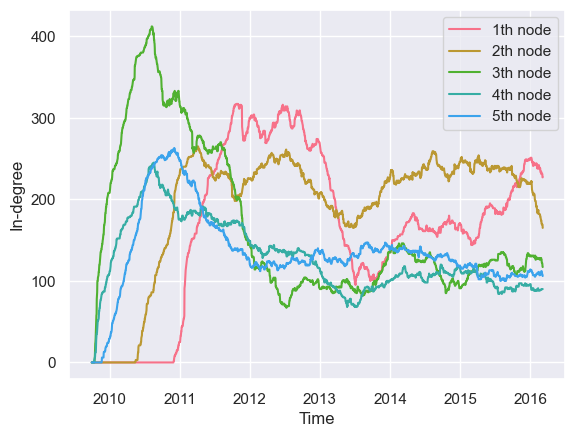

In [16]:
sns.set()
sns.set_palette("husl")

n = 5
leaders = [x[0] for x in degrees[:n]]
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in g.rolling(window=2592000,step=86400)]

fig, ax = plt.subplots()

for i,leader in enumerate(leaders):
    deg = list(map( lambda v: v.in_degree(), g.vertex(leader).rolling(window=25920000,step=86400)))
    ax.plot(timestamps,deg,label=str(i+1)+"th node")

ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("In-degree")
plt.savefig("degree-trajectories-top5.png")
plt.show()

In [17]:
window_sizes = [86400,604800,2592000,31536000]
window_names = ["1 day", "1 week", "1 month", "1 year"]

views = g.expanding(step=86400)
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]
aggr_vertices = [v.num_vertices() for v in views]
aggr_edges = [v.num_edges() for v in views]


agg_window = np.zeros(len(timestamps),dtype=int)
df = pd.DataFrame({"time": timestamps, "window":agg_window, "vertices": aggr_vertices, "edges": aggr_edges})

for i in range(3):
    views = g.rolling(window=window_sizes[i], step=86400)
    diff_size = int(window_sizes[i]/86400)

    timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]
    vertices = [v.num_vertices() for v in views]
    edges = [v.num_edges() for v in views]

    to_join = pd.DataFrame({"time": timestamps, "window":[window_sizes[i] for k in range(len(timestamps))], "vertices": vertices, "edges": edges})
    df = pd.concat([df,to_join],copy=False)

agg_df = df[df["window"]==0]
for w in window_sizes:
    diff_size = int(w / 86400)
    df.loc[df['window'] == w, 'new_vertices'] = pd.Series(df.loc[df['window'] == 0, 'vertices'].diff(diff_size), index = df.loc[df['window'] == w, 'vertices'].index)
    df.loc[df['window'] == w, 'prop_new'] = np.where(df.loc[df['window'] == w, 'vertices'] < 1, 0, df.loc[df['window'] == w, 'new_vertices'] / df.loc[df['window'] == w, 'vertices'])

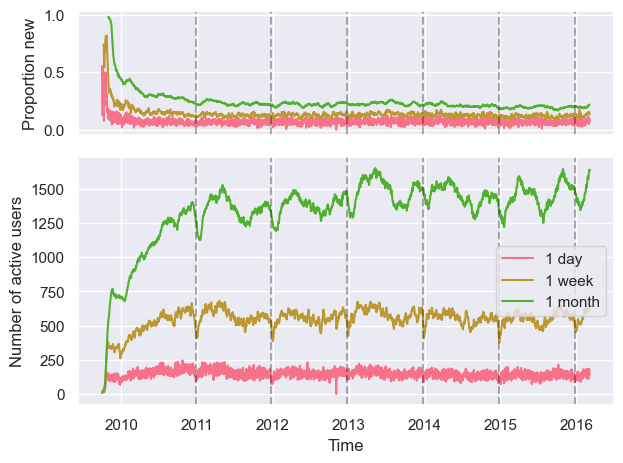

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

for i in range(3):
    sub_df = df[df['window'] == window_sizes[i]]
    ax1.plot(sub_df['time'], sub_df['prop_new'],label=window_names[i])
    ax2.plot(sub_df['time'],sub_df['vertices'],label=window_names[i])

for i in range(6):
    ax1.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)
    ax2.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)

ax2.set_xlabel("Time")
ax1.set_ylabel("Proportion new")
ax2.set_ylabel("Number of active users")

ax2.legend()
plt.tight_layout()
plt.savefig("new-existing-users.png")

In [20]:
from raphtory.nullmodels import *
from raphtory.algorithms import weakly_connected_components
from collections import Counter

experiments = 10

for i in range(3):
    w=window_sizes[i]
    results_vertices = np.zeros((experiments,len(df[df['window']==w])))
    results_edges = np.zeros((experiments,len(df[df['window']==w])))
    for ex in range(experiments):
        sx_shuffled = shuffle_column(sx_df,col_number=2)
        g_shuff = load_pandas(sx_shuffled)
        views = g_shuff.rolling(window=window_sizes[i],step=86400)
        results_vertices[ex,:] = np.array([v.num_vertices() for v in views])
        results_edges[ex,:] = np.array([v.num_edges() for v in views])
    df.loc[df['window'] == w, 'vert_shuffled_mean'] = results_vertices.mean(axis=0)
    df.loc[df['window'] == w, 'vert_shuffled_sd'] = results_vertices.std(axis=0)
    df.loc[df['window'] == w, 'edge_shuffled_mean'] = results_edges.mean(axis=0)
    df.loc[df['window'] == w, 'edge_shuffled_sd'] = results_edges.std(axis=0)

In [22]:
views = g.rolling(window=3600, step=3600)
edges = [v.num_edges() for v in views]

In [55]:
timestamps = [dt.datetime.fromtimestamp(v.latest_time()) for v in views]
to_join = pd.DataFrame({"time": timestamps, "window":[3600 for k in range(len(timestamps))], "vertices": vertices})
df = pd.concat([df,to_join],copy=False)

In [31]:
from raphtory.algorithms import global_clustering_coefficient

for i in range(3):
    w=window_sizes[i]
    results_cc = np.zeros((experiments,len(df[df['window']==w])))
    views = g.rolling(window=window_sizes[i],step=86400)
    cc = [global_clustering_coefficient(v) for v in views]
    for ex in range(experiments):
        sx_shuffled = shuffle_column(sx_df,col_number=2)
        g_shuff = load_pandas(sx_shuffled)
        views = g_shuff.rolling(window=window_sizes[i],step=86400)
        results_cc[ex,:] = np.array([global_clustering_coefficient(v) for v in views])
    df.loc[df['window'] == w, 'cc_shuffled_mean'] = results_cc.mean(axis=0)
    df.loc[df['window'] == w, 'cc_shuffled_sd'] = results_cc.std(axis=0)

In [32]:
df.to_csv("results.csv")

In [20]:
display(df)

,time,window,vertices,edges,new_vertices,prop_new,vert_shuffled_mean,vert_shuffled_sd,edge_shuffled_mean,edge_shuffled_sd
0,2009-09-30 03:56:28,0,10,15,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-10-01 03:56:28,0,11,19,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-10-02 03:56:28,0,16,29,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-10-03 03:56:28,0,21,42,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-10-04 03:56:28,0,23,48,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2345,2016-03-02 02:56:28,2592000,1618,3173,348.0,0.215080,3621.1,36.776215,4528.2,22.413389
2346,2016-03-03 02:56:28,2592000,1619,3169,351.0,0.216800,3649.8,34.362189,4569.2,21.022845
2347,2016-03-04 02:56:28,2592000,1630,3202,357.0,0.219018,3674.7,34.316323,4622.8,24.628439
2348,2016-03-05 02:56:28,2592000,1642,3188,358.0,0.218027,3649.5,35.014997,4567.1,25.594726


In [60]:
df['week_days'] = df["time"].apply(lambda x: x.weekday())
df['hour'] = df["time"].apply(lambda x: x.hour)

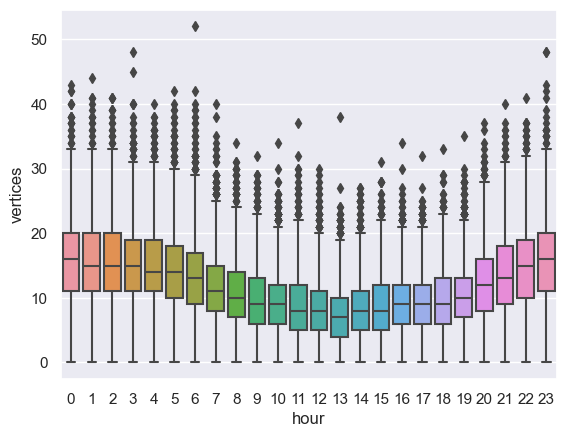

In [61]:
ax = sns.boxplot(data=df[df['window']==3600], x='hour', y='vertices')

<AxesSubplot:>

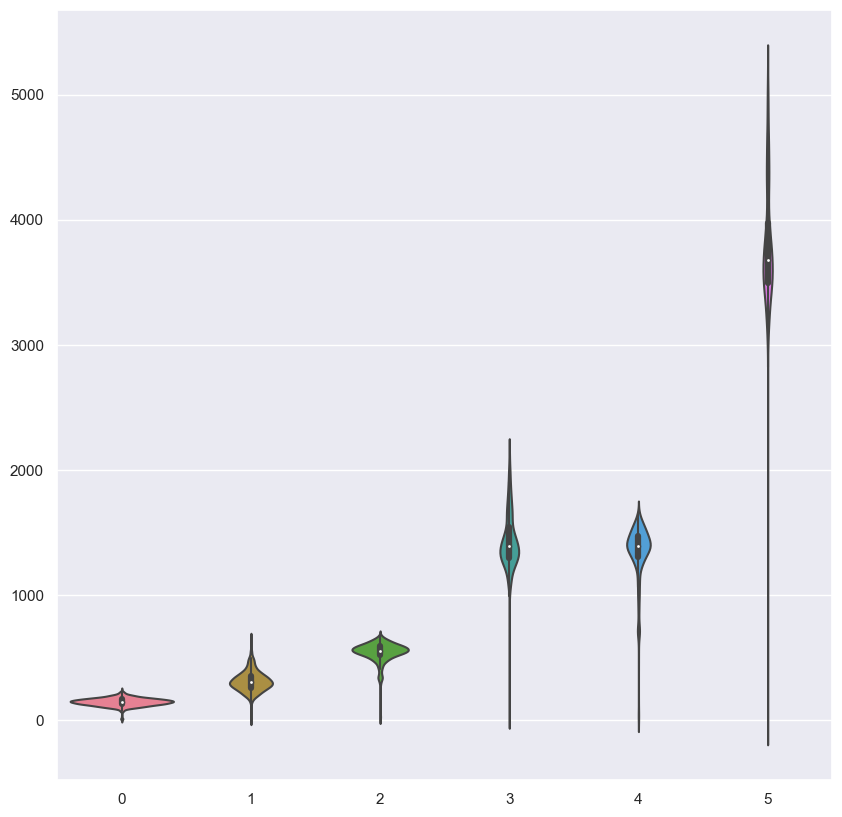

In [73]:
fig, ax = plt.subplots(1, figsize=(10, 10))
to_plot = []
for i in range(3):
    real = list(df[df['window']==window_sizes[i]]['vertices'])
    shuffled = list(df[df['window']==window_sizes[i]]['vert_shuffled_mean'])
    to_plot.append(real)
    to_plot.append(shuffled)

sns.violinplot(data=to_plot, )

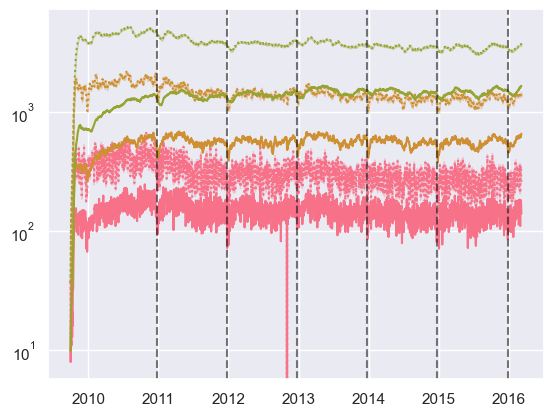

In [41]:
fig, ax = plt.subplots()

colors = sns.color_palette("husl",8)

for i in range(3):
    col = colors[i]
    sub_df = df[df['window'] == window_sizes[i]]
    ax.plot(sub_df['time'],sub_df['vertices'],label=window_names[i],color=col)
    ax.plot(sub_df['time'],sub_df['vert_shuffled_mean'],label=window_names[i], linestyle=":",color=col)
    ax.fill_between(sub_df['time'],sub_df['vert_shuffled_mean']-sub_df['vert_shuffled_sd'],sub_df['vert_shuffled_mean']+sub_df['vert_shuffled_sd'], alpha=0.3,color=col)

ax.set_yscale('log')

for i in range(6):
    ax.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)
    ax.axvline(dt.datetime(2010+i,12,25),color="black",linestyle="--", alpha=0.3)

In [15]:
display(sx_shuffled)
display(sx_df)

,src,dst,time
0,1,4,1267103182
1,3,4,1275768875
2,1,2,1302355727
3,25,1,1401114174
4,14,16,1263710769
...,...,...,...
506545,21349,88580,1256868896
506546,20031,1114,1318246833
506547,51428,1114,1260285936
506548,56259,56259,1282341072


,src,dst,time
0,1,4,1254192988
1,3,4,1254194656
2,1,2,1254202612
3,25,1,1254232804
4,14,16,1254263166
...,...,...,...
506545,21349,88580,1457260401
506546,20031,1114,1457261526
506547,51428,1114,1457261724
506548,56259,56259,1457261848


In [20]:
g = load_pandas(sx_df)

In [50]:
edges = [
                (1, 1, 2),
                (2, 1, 3),
                (3, 1, 4),
                (4, 3, 1),
                (5, 3, 4),
                (6, 3, 5),
                (7, 4, 5),
                (8, 5, 6),
                (9, 5, 8),
                (10, 7, 5),
                (11, 8, 5),
                (12, 1, 9),
                (13, 9, 1),
                (14, 6, 3),
                (15, 4, 8),
                (16, 8, 3),
                (17, 5, 10),
                (18, 10, 5),
                (19, 10, 8),
                (20, 1, 11),
                (21, 11, 1),
                (22, 9, 11),
                (23, 11, 9),
            ]

In [51]:
g_test = rp.Graph()
for e in edges:
    g_test.add_vertex(e[0],e[1])
    g_test.add_vertex(e[0],e[2])
    g_test.add_edge(e[0],e[1],e[2])

In [7]:
from raphtory.algorithms import all_local_motifs
counts = all_local_motifs(g,3600)

In [8]:
df = pd.DataFrame(counts).transpose()

In [9]:
# display(df)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
1992,3,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
29293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29634,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
56384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
print(rp.algorithms.local_triangle_count(g,12940))

9
Edges(Edge(source=290, target=12940, earliest_time=1300516165, latest_time=1300516165), Edge(source=1149, target=12940, earliest_time=1300538744, latest_time=1300538744), Edge(source=1437, target=12940, earliest_time=1300519179, latest_time=1300519179), Edge(source=6976, target=12940, earliest_time=1300525737, latest_time=1300525737), Edge(source=7666, target=12940, earliest_time=1300581906, latest_time=1300581906), Edge(source=12940, target=7666, earliest_time=1300597288, latest_time=1300597391), Edge(source=12940, target=7666, earliest_time=1300597288, latest_time=1300597391), Edge(source=11771, target=12940, earliest_time=1300588535, latest_time=1300588535), Edge(source=13302, target=12940, earliest_time=1301412397, latest_time=1301412397), Edge(source=12940, target=13302, earliest_time=1301527891, latest_time=1301527891))


In [10]:
motifs = np.array(df.sum(axis=0))
motifs[32:] = motifs[32:]/3
print(motifs[24:])

[16637  1930   836  4088  4088   836  1930 16637  2553  2635   898   197
   501  2027  1109   651]


In [11]:
motifs_3d = to_3d_heatmap(motifs)

In [12]:
print(motifs_3d)

[[17595  3826  2553   501  6088 22084]
 [ 2012  1621   898   197  3543   996]
 [ 2045  2676  2044  5964  2635  2027]
 [ 4395  1615  8820  1687  1109   651]
 [  836  4088  1477  3219  2323  4780]
 [16637  1930  9213  5081  3317 21493]]


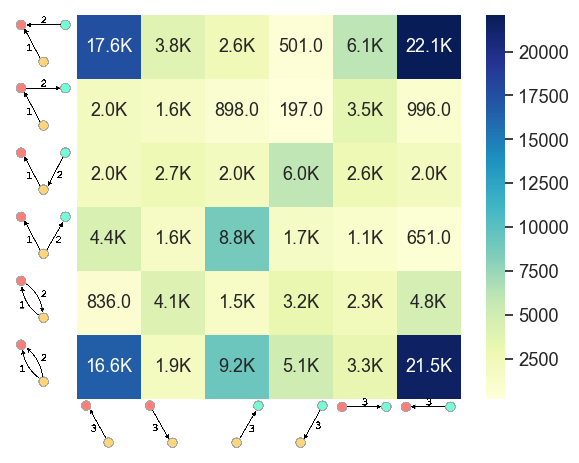

In [14]:
fig, ax = plt.subplots()

labels = get_labels(motifs_3d)
ax = sns.heatmap(motifs_3d,square=True,  cmap="YlGnBu", cbar=True, annot=labels,annot_kws={"size":13}, fmt='', cbar_kws={"shrink": 1.0})

for i in range(6):
    offset_image("x",i,i,ax)
    offset_image("y",i,i,ax)

ax.tick_params(axis='x', which='major', pad=50)
ax.tick_params(axis='y', which='major', pad=50)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig("sx-motifs-all.png")